# Import

In [1]:
import sys
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
from baselines.utils.inter_utils import *
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader, Dataset
device = get_device()
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt

Using CPU
Recommend using GPU for faster training


# Settings

In [2]:
#Settings
#Instead of using argparse set the arguments here
min_size = 300
max_size = 500
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class settings:
    dataframe = "datasets/T10LOT/T10LOT/T10LOT_dataframe.csv"
    path =  "datasets/T10LOT/T10LOT"
    model_type = "retinanet_mobilenet"
    batch_size = 1

# Training input visualization
Creates a dateset function and then reads from it and plot it with ROI included

In [1]:
from baselines.utils.process_data import get_dataframe

get_dataframe("datasets/PKLot")

KeyboardInterrupt: 

In [4]:
from baselines.utils.inter_utils import *
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
device = get_device()

dataset = "T10LOT"

dataset_path = os.path.join("datasets/"+dataset, dataset)
model = get_model(retinanet_mobilenet_params)
load_model(model, device, "Saved_Models/retinanet_mobilenet/state_dict_100.pth")
model.to(device);

DIR_INPUT = os.path.join(dataset_path, 'splitted_images')
DIR_TEST = f'{DIR_INPUT}/test'
dataframe = pd.read_csv("datasets/"+str(dataset)+"/"+str(dataset)+"/"+str(dataset)+"_dataframe.csv")

test_df = get_testDataframe(dataframe)

# dataloaders
test_dataset = ParkDataset(test_df, DIR_TEST, get_valid_transform())

# Make a testing DataLoader
test_data_loader = DataLoader(
    test_dataset,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)
#show_from_dataset(2, test_data_loader)
acc_list = test_model(model, test_data_loader, 0.5)
avg_acc = sum(acc_list) / len(acc_list)
print("Average accuracy on test dataset: %0.2f %%" %(avg_acc*100))

Using CPU
Recommend using GPU for faster training
Average accuracy on test dataset: 0.00 %


# Inference
From a saved model dict

Using CPU
Recommend using GPU for faster training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


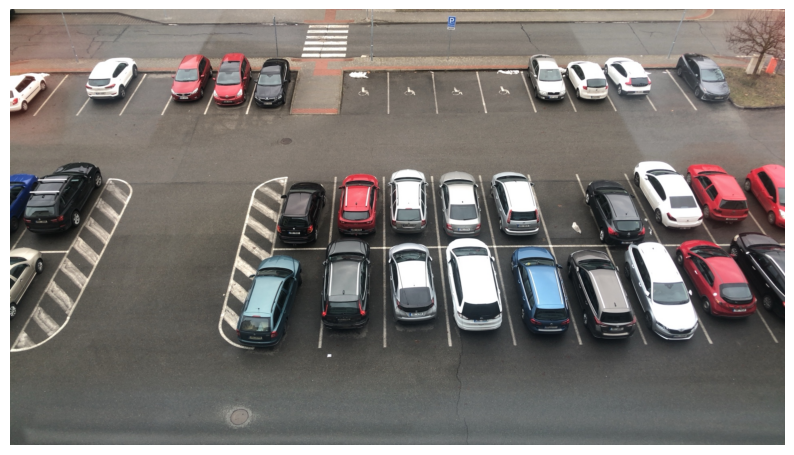

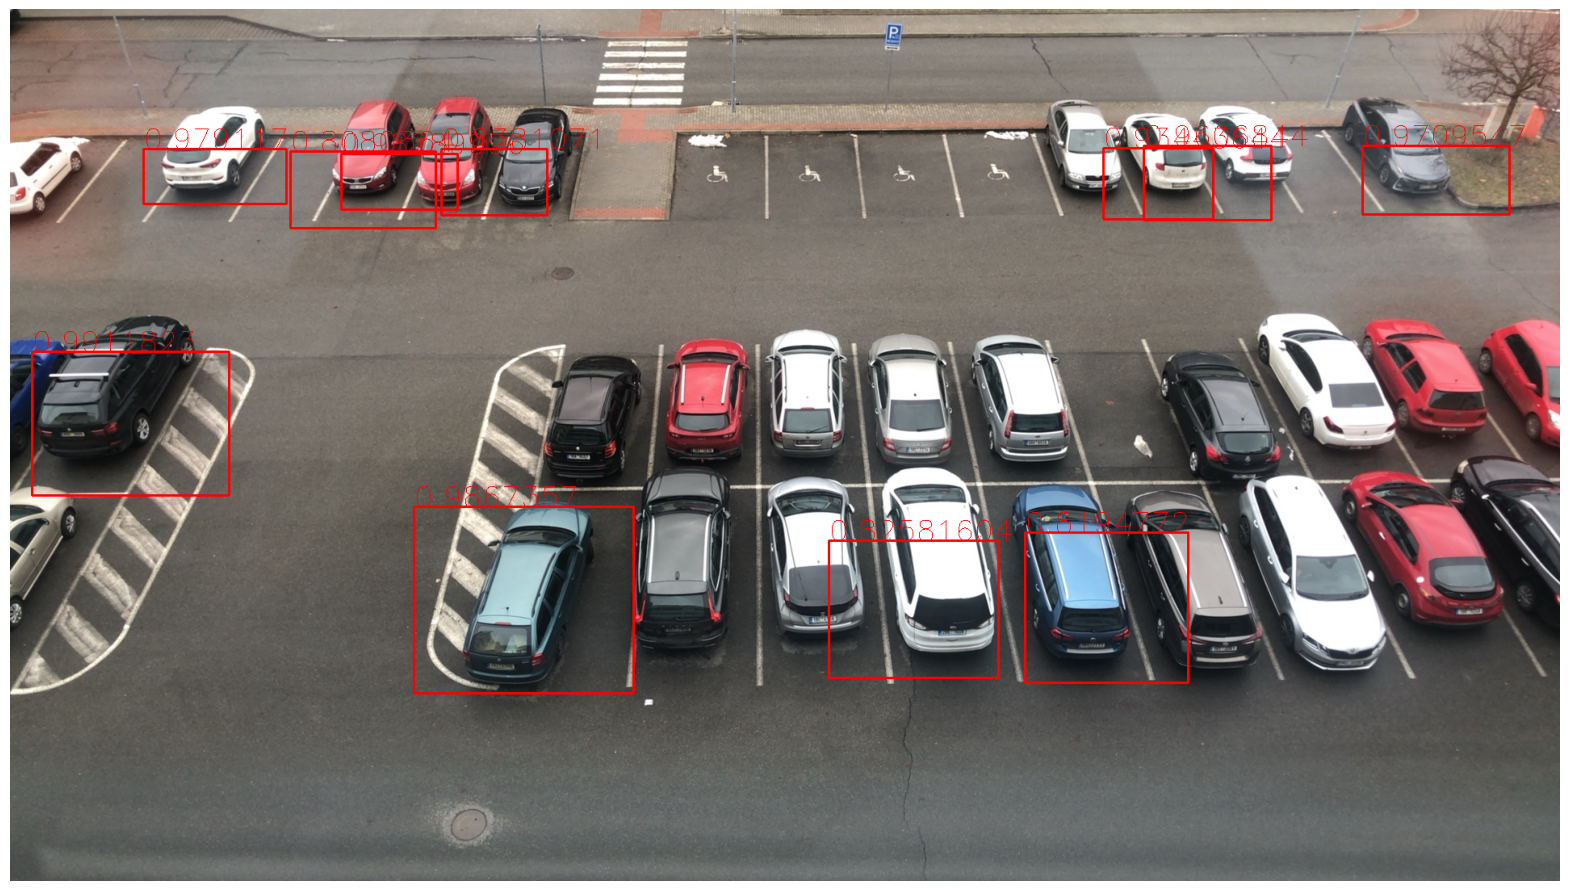

In [4]:
from torchvision import transforms

#Path settings
saved_model = f"Saved_Models/model-data_comet-torch-model-45099.pth"
image_path = f"datasets/T10LOT/T10LOT/splitted_images/test/Picture0090.jpg"


#Model intialization 
device = get_device()
model = get_model(faster_rcnn_mobilenet_params)
if device.type == 'cpu':
    model.load_state_dict(torch.load(saved_model, map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load(saved_model))
    model.cuda()
    
#Image loading
image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

#Image transofrmation and preprocessing
preprocess = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
    # normalize the colors to the range that mobilenet_v2/3 expect
    #transforms.Normalize(mean=mean, std=std),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
plt.figure(figsize=(10,10))
plt.imshow(input_batch[0].permute(1,2,0))
plt.axis("off")

#Running inference
model.eval()
with torch.no_grad():
    input_batch = input_batch.to(device)
    show_inference(input_batch, model, image, 0.8)